# Problem Definition

This notebook addresses one of classical NLP problems "Homonyms"

Homonyms refer to words with the same spelling and pronunciation but multiple meanings like for example the one shown here in the image.

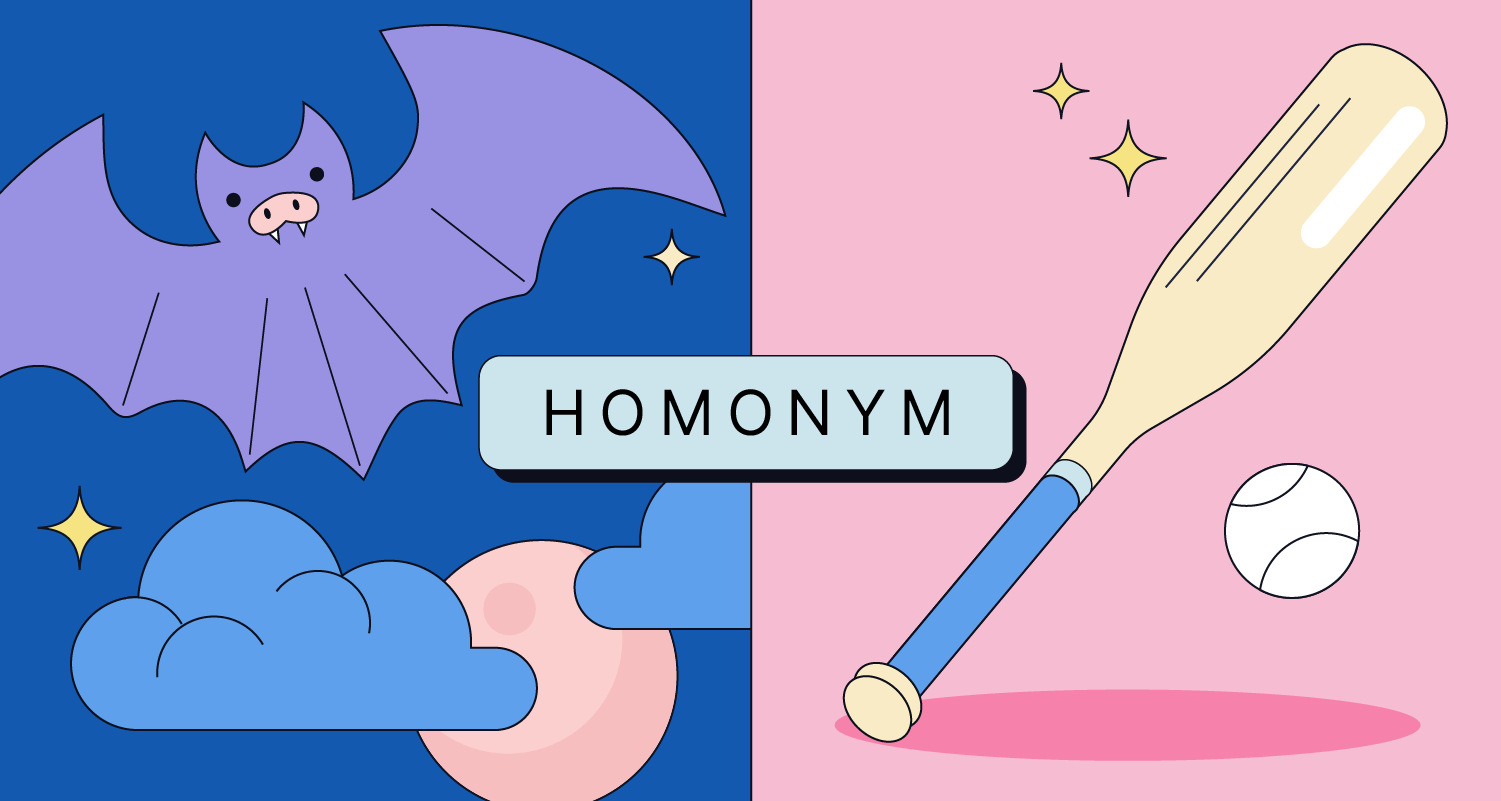

# Install Independencies

In [ ]:
!pip install transformers datasets

# Importing needed Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from datasets import load_dataset, concatenate_datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support
)
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from bs4 import BeautifulSoup
import re
import string
import unicodedata
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    BertTokenizerFast,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    pipeline,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments
)
import torch
from torch.utils.data import Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (
    Dense,
    Input,
    Embedding,
    LSTM,
    Dropout,
    Conv1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    Bidirectional,
    Flatten,
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import plotly.express as px

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Choice of the dataset

I am trying to determine which dataset to go with, the choice is not solely based on sentiment analysis, I am trying to pick one that's rich with homonyms.

So, I  implemented a function to help me settle between  Stanford Sentiment Treebank or the IMDb dataset.

## Loading Dataset

In [ ]:
imdb_movies = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [ ]:
imdb_movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
imdb_movies.shape

(50000, 2)

In [ ]:
sst = load_dataset("stanfordnlp/sst2")

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
sst

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [ ]:
# Display the first example in the training set
print(sst['train'][0])

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [ ]:
# Combine the train, validation, and test sst
sst_combined = concatenate_datasets([sst['train'], sst['validation'], sst['test']])
sst_combined_df = sst_combined.to_pandas()
sst_combined_df.head()

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [ ]:
# Check label distribution for IMDB
imdb_movies['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [ ]:
# Check label distribution for SST
sst_combined_df["label"].value_counts()

label
 1    38013
 0    30208
-1     1821
Name: count, dtype: int64

## Check Words count distribution

For working with homonyms, it's better to choose a dataset with short to medium-length sentences, especially when focusing on resolving contextual ambiguity in sentiment analysis as long sentences often introduce multiple ideas or clauses, which can dilute the focus on the homonym and complicate the analysis.

In [ ]:
sst["train"]["sentence"][6]

'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . '

In [ ]:
imdb_movies["review"][10]

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

Text(0, 0.5, 'Frequency')

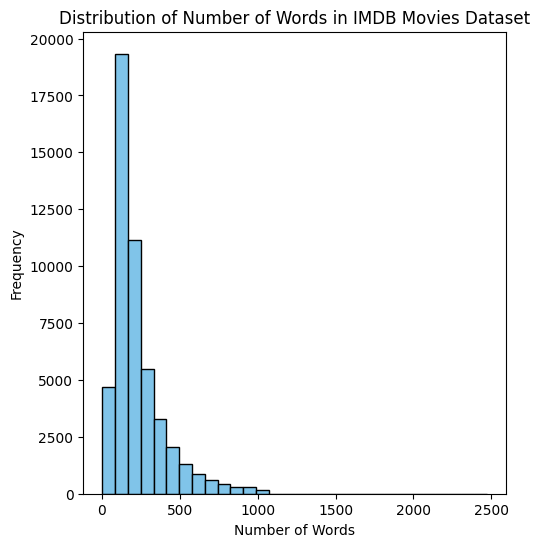

In [ ]:
imdb_movies['review_token_count'] = imdb_movies['review'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.figure(figsize=(12, 6))

# Plot for positive reviews
plt.subplot(1, 2, 1)
plt.hist(imdb_movies['review_token_count'], bins=30, color='#80C4E9', edgecolor='black')
plt.title('Distribution of Number of Words in IMDB Movies Dataset')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

In [ ]:
imdb_movies.tail()

,review,sentiment,review_token_count
49995,I thought this movie did a down right good job...,positive,194
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,112
49997,I am a Catholic taught in parochial elementary...,negative,230
49998,I'm going to have to disagree with the previou...,negative,212
49999,No one expects the Star Trek movies to be high...,negative,129


In [ ]:
sst_combined_df["word_count"] = sst_combined_df["sentence"].apply(lambda x: len(x.split()))
sst_combined_df.head()

,idx,sentence,label,word_count
0,0,hide new secretions from the parental units,0,7
1,1,"contains no wit , only labored gags",0,7
2,2,that loves its characters and communicates som...,1,12
3,3,remains utterly satisfied to remain the same t...,0,8
4,4,on the worst revenge-of-the-nerds clichés the ...,0,10


Text(0, 0.5, 'Frequency')

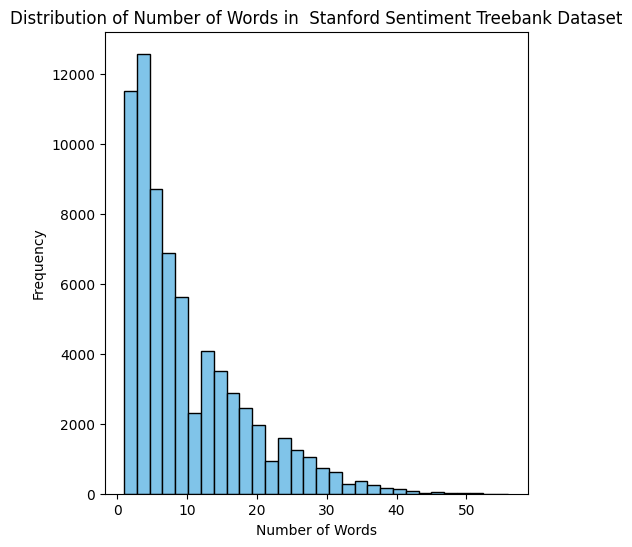

In [ ]:
# Plot the distribution
plt.figure(figsize=(12, 6))

# Plot for positive reviews
plt.subplot(1, 2, 1)
plt.hist(sst_combined_df['word_count'], bins=30, color='#80C4E9', edgecolor='black')
plt.title('Distribution of Number of Words in  Stanford Sentiment Treebank Dataset')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

## Check for homonyms

In [ ]:
# Function to check for homonyms in sentences across datasets
homonyms = ["bat", "trunck", "park", "bark", "bank", "rock", "saw", "row", "bow", "tear", "match", "spring", "lead", "duck"]

def find_homonyms(data, homonym_list):
  # A dictionary is created to store the count of each homonym. Initially, all counts are set to zero.
    homonym_counts = {homonym: 0 for homonym in homonym_list}
    # Another dictionary is created to store the sentences containing each homonym.
    matching_sentences = {homonym: [] for homonym in homonym_list}

    for sentence in data:  # Directly iterate through the list of sentences
        for homonym in homonym_list:
            if homonym in sentence.lower():  # Case insensitive match
                homonym_counts[homonym] += 1
                matching_sentences[homonym].append(sentence)

    return homonym_counts, matching_sentences

In [ ]:
# Find sentences with homonyms and get counts
homonym_counts_imdb, homonym_sentences_imdb = find_homonyms(imdb_movies['review'], homonyms)
homonym_counts_sst, homonym_sentences_sst = find_homonyms(sst_combined_df['sentence'], homonyms)
# Display the counts for both datasets
print("Homonym counts in IMDb dataset:", homonym_counts_imdb)
print("Homonym counts in SST dataset:", homonym_counts_sst)

Homonym counts in IMDb dataset: {'bat': 3513, 'trunck': 0, 'park': 1512, 'bark': 310, 'bank': 645, 'rock': 2005, 'saw': 5796, 'row': 7295, 'bow': 654, 'tear': 959, 'match': 1035, 'spring': 415, 'lead': 5407, 'duck': 223}
Homonym counts in SST dataset: {'bat': 179, 'trunck': 0, 'park': 213, 'bark': 14, 'bank': 34, 'rock': 194, 'saw': 67, 'row': 892, 'bow': 96, 'tear': 151, 'match': 79, 'spring': 49, 'lead': 261, 'duck': 19}


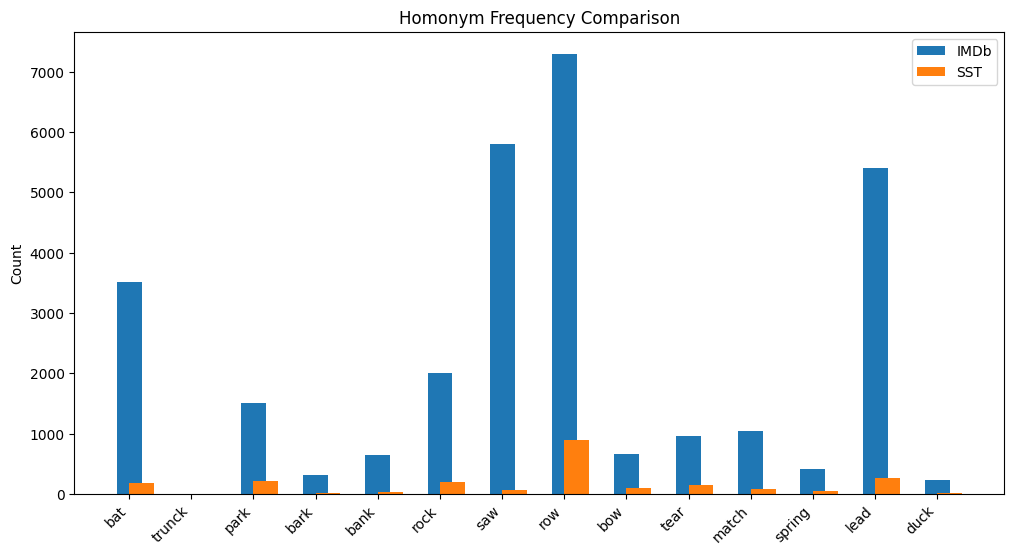

In [ ]:
labels = list(homonym_counts_imdb.keys())
imdb_values = list(homonym_counts_imdb.values())
sst_values = list(homonym_counts_sst.values())

# Visualize the counts
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar charts
ax.bar(labels, imdb_values, width=0.4, label='IMDb', align='center')
ax.bar(labels, sst_values, width=0.4, label='SST', align='edge')

# Set labels and title
ax.set_ylabel('Count')
ax.set_title('Homonym Frequency Comparison')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

**IMDB Strengths:**

*   Contains more diverse contexts and longer reviews, which often include homonyms in natural, unstructured text.
*   More data for ambiguous words like "bat," "row," and "lead," offering better real-world disambiguation opportunities.



**SST Strengths:**


*   Sentences are shorter and more focused, potentially making homonym disambiguation simpler.
*   Easier to analyze due to the smaller size and structured format.

Based on my task (homonyms in sentiment analysis), I will settle with the IMDB dataset as it has more occurrences of homonyms in varied contexts, and its larger size provides more data to train and evaluate, also the class label is balanced.

# Preprocessing & EDA

Unlike earlier NLP models, Transformer-based models such as BERT require minimal preprocessing. Steps such as removing stop words and punctuation can prove counterproductive in some cases, since these elements provide BERT with valuable context for understanding the input sentences. Nevertheless, it is still important to inspect the text to check for any formatting issues or unwanted characters, also if we choose to preprocess, just ensure it doesn't remove essential information.

I will be conducting an experiment one with comprehensive cleaning and another with minimal cleaning

In [ ]:
imdb_movies.tail()

,review,sentiment,review_token_count
49995,I thought this movie did a down right good job...,positive,194
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,112
49997,I am a Catholic taught in parochial elementary...,negative,230
49998,I'm going to have to disagree with the previou...,negative,212
49999,No one expects the Star Trek movies to be high...,negative,129


In [ ]:
imdb_movies["review"][49995]

"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like it, and when it comes out on DVD I'm going to pay the money for it very proudly, every last cent. Sharon Stone is great, she always is, even if her movie is horrible(Catwoman), but this movie isn't, this is one of those movies that will be underrated for its lifetime, and it will probably become a classic in like 20 yrs. Don't wait for it to be a classic, watch it now and enjoy it. Don't expect a masterpiece, or something thats gripping and soul touching, just allow yourself to get out of your life and get yourself involved in theirs.<br /><br />All in all, this movie is entertaining and i recommend people who haven't seen it see it, because what the critics and box office say doesn't always count, see it for yourself, you never know, you might just enjoy it. I tip my hat to this movie<br /><

The data contains HTML tags that should be removed.

In [ ]:
imdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review              50000 non-null  object
 1   sentiment           50000 non-null  object
 2   review_token_count  50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
imdb_movies.describe()

,review_token_count
count,50000.000000
mean,231.156940
std,171.343997
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


In [ ]:
# Check for missing values
imdb_movies.isnull().sum()

review                0
sentiment             0
review_token_count    0
dtype: int64

In [ ]:
# Check for duplicates
imdb_movies.duplicated().sum()

418

In [ ]:
# View duplicated reviews
duplicated_reviews = imdb_movies[imdb_movies["review"].duplicated()]
duplicated_reviews

,review,sentiment,review_token_count
3537,Quite what the producers of this appalling ada...,negative,401
3769,My favourite police series of all time turns t...,positive,94
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive,110
6352,If you liked the Grinch movie... go watch that...,negative,100
6479,I want very much to believe that the above quo...,negative,446
...,...,...,...
49912,This is an incredible piece of drama and power...,positive,170
49950,This was a very brief episode that appeared in...,negative,199
49984,Hello it is I Derrick Cannon and I welcome you...,negative,417
49986,This movie is a disgrace to the Major League F...,negative,118


In [ ]:
# Drop duplicate reviews
imdb_movies.drop_duplicates(inplace = True)

In [ ]:
# Recheck for duplicates
imdb_movies.duplicated().sum()

0

## Cleaning Methodology

In [ ]:
# This dictionary maps contractions to their expanded forms.
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [ ]:
def expand_contractions(text):
    for contraction, expansion in mapping.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expansion, text)
    return text

# Function to remove URLs
def remove_urls(text):
    return re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

# Function to remove HTML tags
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))  # Get stopwords list
    # Tokenize the text and filter out stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Function to remove extra white spaces
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# Combined cleaning function
def deep_cleaning(text):
    text = text.lower()  # Lowercasing
    text = expand_contractions(text)  # Expand contractions
    text = remove_urls(text)  # Remove URLs
    text = remove_html_tags(text)  # Remove HTML tags
    text = remove_punctuation(text)  # Remove punctuation
    text = remove_emojis(text)  # Remove emojis
    text = remove_stop_words(text)  # Remove stopwords
    text = remove_extra_spaces(text)  # Remove extra spaces
    return text

## Comprehensive Cleaning

In [ ]:
cleaned_df_deep = [deep_cleaning(review) for review in imdb_movies["review"]]

In [ ]:
 # Check the first two cleaned reviews
cleaned_df_deep[:2]

['one reviewers mentioned watching 1 oz episode hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows would dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison 

In [ ]:
# Combine the sentiment column and convert it back to dataframe
cleaned_df_deep = pd.DataFrame({
    "review": cleaned_df_deep,
    "sentiment": imdb_movies["sentiment"]
})

In [ ]:
cleaned_df_deep.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matteis love time money visually stunni...,positive


In [ ]:
cleaned_df_deep.to_csv("imdb_deep_cleaned.csv", index=False)

In [ ]:
cleaned_df_deep.shape

(49582, 2)

## Minimal Cleaning

In [ ]:
def minimal_clean(text):
    text = remove_urls(text)  # Remove URLs
    text = remove_html_tags(text)  # Remove HTML tags
    text = remove_extra_spaces(text)  # Remove extra spaces
    return text

In [ ]:
cleaned_df_minimal = [minimal_clean(review) for review in imdb_movies["review"]]

In [ ]:
# Combine the sentiment column and convert it back to dataframe
cleaned_df_minimal = pd.DataFrame({
    "review": cleaned_df_minimal,
    "sentiment": imdb_movies["sentiment"]
})

In [ ]:
cleaned_df_minimal.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
cleaned_df_minimal.to_csv("imdb_minimal_cleaned.csv", index=False)

## Exploaraty Data Analysis

/tmp/ipykernel_30/1024892071.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = sentiment_percentages[i]


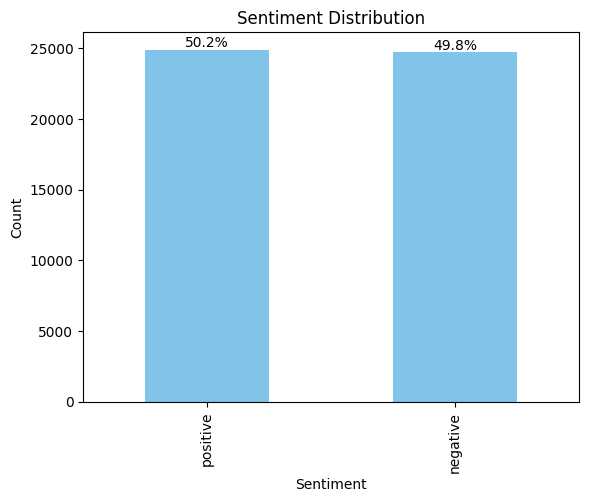

In [ ]:
# Calculate value counts and percentages
sentiment_counts = cleaned_df_deep['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100

# Plot the sentiment distribution with the specified color
ax = sentiment_counts.plot(kind='bar', color='#80C4E9')

# Add title and labels
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display percentages on top of each bar
for i, count in enumerate(sentiment_counts):
    percentage = sentiment_percentages[i]
    ax.text(i, count + 1, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the plot
plt.show()

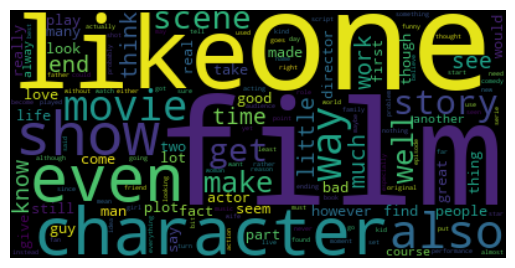

In [ ]:
# Wordcloud for all data
all_reviews = ' '.join(cleaned_df_deep['review'])
wordcloud = WordCloud(stopwords='english').generate(all_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

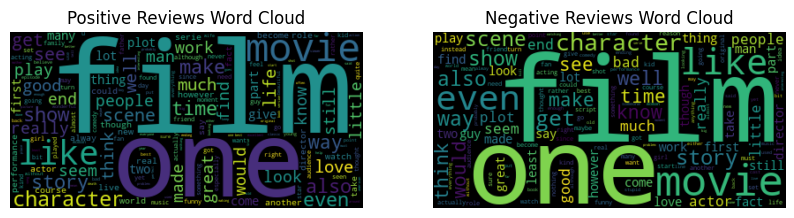

In [ ]:
# Wordcloud for positive and negative reviews
positive_reviews = ' '.join(cleaned_df_deep[cleaned_df_deep['sentiment'] == 'positive']['review'])
negative_reviews = ' '.join(cleaned_df_deep[cleaned_df_deep['sentiment'] == 'negative']['review'])

positive_wordcloud = WordCloud(stopwords='english').generate(positive_reviews)
negative_wordcloud = WordCloud(stopwords='english').generate(negative_reviews)

# Plot positive word cloud
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

# Plot negative word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')

# Show the plot
plt.show()

I am going now to check for word distribution in the data as Transformers like BERT, and others typically require fixed-length input sequences (tokens). The maximum input length can vary depending on the transformer model (e.g., 512 tokens for BERT). If the length of the text exceeds this limit, we must decide how to handle it (e.g., truncation or splitting).

In [ ]:
# Find the maximum number of words in a review
cleaned_df_deep['review_token_count'] = cleaned_df_deep['review'].apply(lambda x: len(x.split()))
max_tokens = cleaned_df_deep['review_token_count'].max()

print(f"The maximum number of words in a single review is: {max_tokens}")

# Print column with maximum number of words
max_token_reviews = cleaned_df_deep[cleaned_df_deep['review_token_count'] == max_tokens]
print(max_token_reviews[['review']])

The maximum number of words in a single review is: 1418
                                                  review
31481  match 1 tag team table match bubba ray spike d...


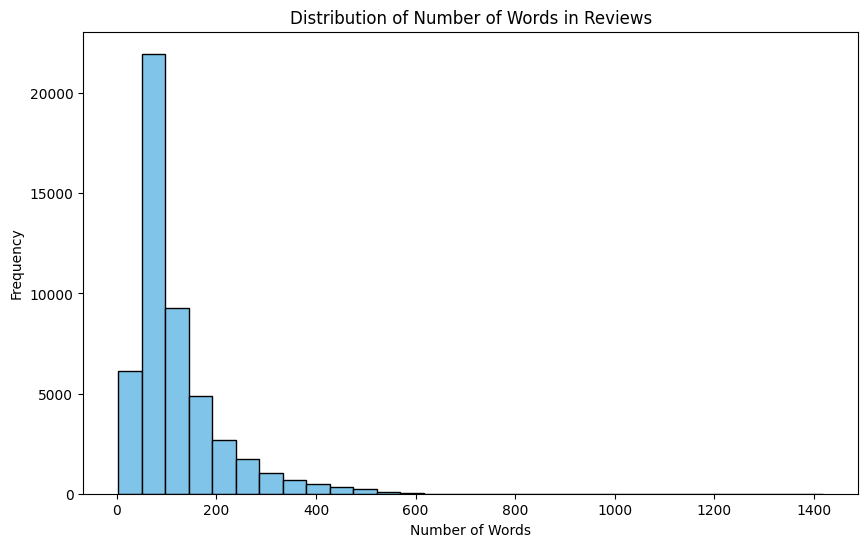

In [ ]:
# Plot the distribution of token counts
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df_deep['review_token_count'], bins=30, color='#80C4E9', edgecolor='black')
plt.title('Distribution of Number of Words in Reviews')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_30/3680698892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['review_token_count'] = positive_reviews['review'].apply(lambda x: len(x.split()))
/tmp/ipykernel_30/3680698892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['review_token_count'] = negative_reviews['review'].apply(lambda x: len(x.split()))


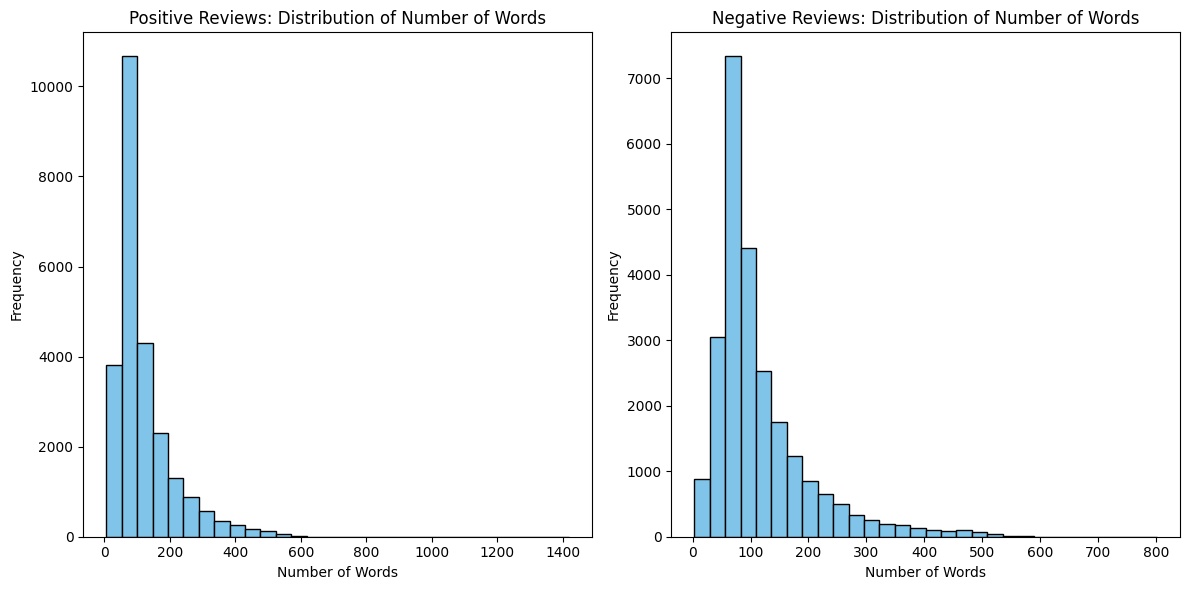

In [ ]:
# Separate positive and negative reviews based on sentiment
positive_reviews = cleaned_df_deep[cleaned_df_deep['sentiment'] == 'positive']
negative_reviews = cleaned_df_deep[cleaned_df_deep['sentiment'] == 'negative']

# Calculate the token count for positive and negative reviews
positive_reviews['review_token_count'] = positive_reviews['review'].apply(lambda x: len(x.split()))
negative_reviews['review_token_count'] = negative_reviews['review'].apply(lambda x: len(x.split()))

# Plot the distribution of token counts for positive and negative reviews
plt.figure(figsize=(12, 6))

# Plot for positive reviews
plt.subplot(1, 2, 1)
plt.hist(positive_reviews['review_token_count'], bins=30, color='#80C4E9', edgecolor='black')
plt.title('Positive Reviews: Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Plot for negative reviews
plt.subplot(1, 2, 2)
plt.hist(negative_reviews['review_token_count'], bins=30, color='#80C4E9', edgecolor='black')
plt.title('Negative Reviews: Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

Positive reviews tend to be longer than negative reviews. This might indicate that satisfied customers are more likely to provide detailed feedback.

Both distributions are right-skewed, suggesting that a majority of reviews are relatively short.

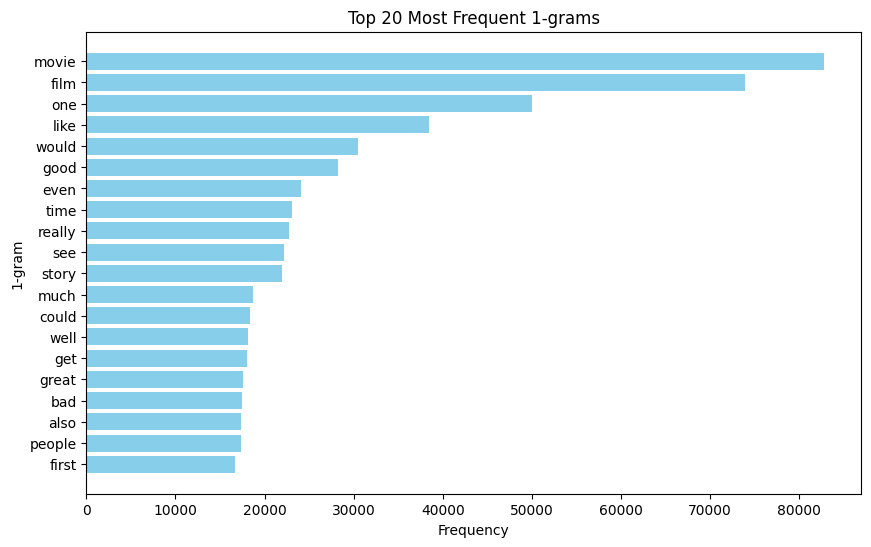

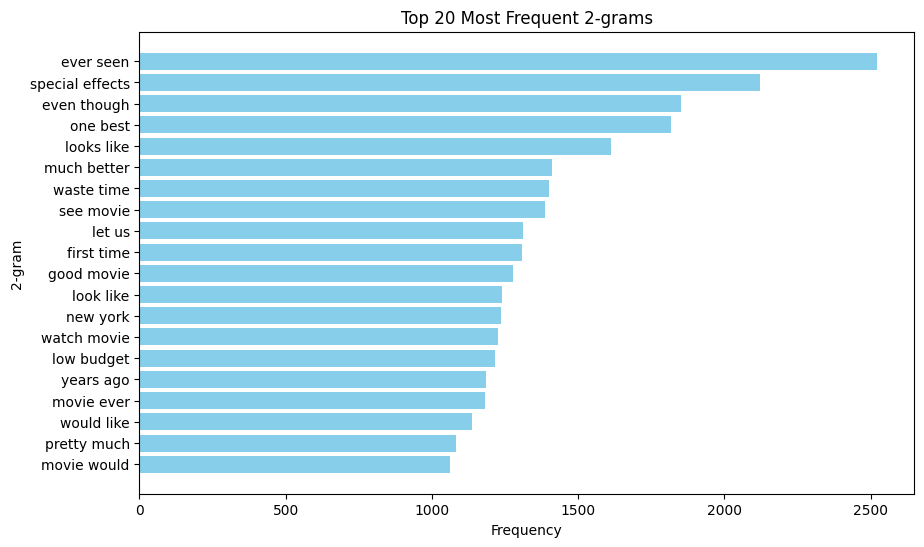

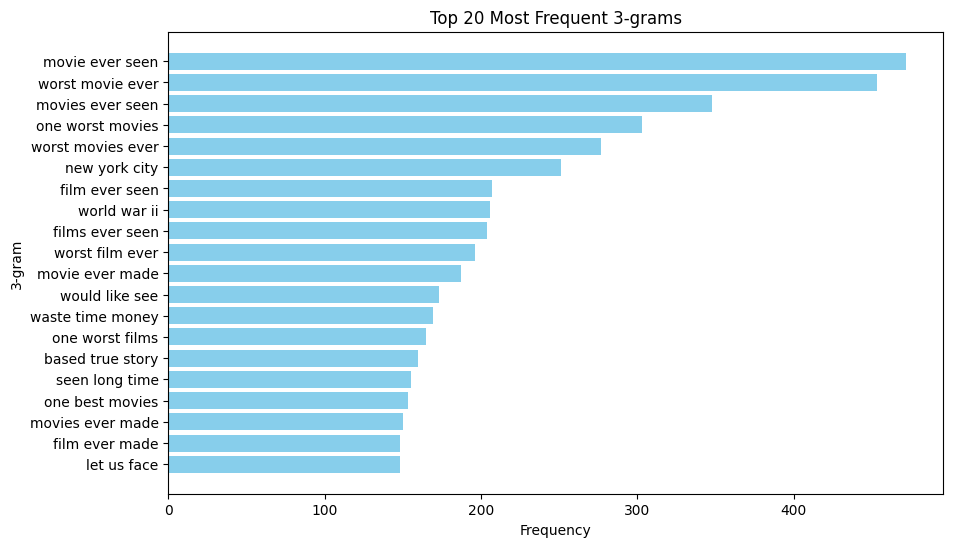

In [ ]:
# Function to get top n-grams and their frequencies
def get_top_text_ngrams(corpus, n, g):
    # Initialize CountVectorizer
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    ngrams = vec.get_feature_names_out()

    # Create a list of tuples (ngram, frequency)
    ngram_freq = [(ngrams[i], sum_words[0, i]) for i in range(len(ngrams))]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)

    # Return the top n grams
    return ngram_freq[:n]

# Function to visualize top n-grams for any n-gram size
def plot_top_ngrams(ngram_freq, top_n, g):
    # Get the top n items from the list of tuples (ngram, frequency)
    sorted_ngrams = ngram_freq[:top_n]

    # Unzip the sorted ngram_freq into two lists: ngrams and frequencies
    ngrams, frequencies = zip(*sorted_ngrams)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(ngrams, frequencies, color='skyblue')

    # Add labels and title
    plt.xlabel('Frequency')
    plt.ylabel(f'{g}-gram')
    plt.title(f'Top {top_n} Most Frequent {g}-grams')
    plt.gca().invert_yaxis()  # To display the highest frequency at the top
    plt.show()

# Example Usage

# Assuming cleaned_df_deep.review is your corpus (list of text data)
# Replace 'cleaned_df_deep.review' with your actual data variable

# Step 1: Generate n-grams (unigrams, bigrams, trigrams)
# For unigrams (1-gram)
most_common_uni = get_top_text_ngrams(cleaned_df_deep.review, 20, 1)

# For bigrams (2-grams)
most_common_bi = get_top_text_ngrams(cleaned_df_deep.review, 20, 2)

# For trigrams (3-grams)
most_common_tri = get_top_text_ngrams(cleaned_df_deep.review, 20, 3)

# Step 2: Visualize the n-grams
# Visualizing top 20 unigrams
plot_top_ngrams(most_common_uni, 20, 1)

# Visualizing top 20 bigrams
plot_top_ngrams(most_common_bi, 20, 2)

# Visualizing top 20 trigrams
plot_top_ngrams(most_common_tri, 20, 3)

## Encoding Target Column

The last step of the preprocessing is to encode the sentiment of each review.

In [ ]:
# Directly assigning the modified column back to the DataFrame
cleaned_df_deep['sentiment'] = cleaned_df_deep['sentiment'].replace("positive", 1).replace("negative", 0)

cleaned_df_minimal['sentiment'] = cleaned_df_minimal['sentiment'].replace("positive", 1).replace("negative", 0)

In [ ]:
cleaned_df_minimal

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
cleaned_df_deep

,review,sentiment,review_token_count
0,one reviewers mentioned watching 1 oz episode ...,1,164
1,wonderful little production filming technique ...,1,84
2,thought wonderful way spend time hot summer we...,1,85
3,basically family little boy jake thinks zombie...,0,64
4,petter matteis love time money visually stunni...,1,125
...,...,...,...
49995,thought movie right good job creative original...,1,78
49996,bad plot bad dialogue bad acting idiotic direc...,0,56
49997,catholic taught parochial elementary schools n...,0,114
49998,going disagree previous comment side maltin on...,0,113


# ML baseline
For the ML-based approach, I will be working with data that's deeply cleaned.

## Logistic Regression

In [ ]:
# Split data
x_train,x_test,y_train,y_test = train_test_split(cleaned_df_deep.review,cleaned_df_deep.sentiment, test_size=0.2, random_state = 42 , stratify = cleaned_df_deep.sentiment)

TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) captures the importance of words in a document relative to the dataset

In [ ]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000)

# Fit and transform the data
X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

In [ ]:
# Train a Logistic Regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4940
           1       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



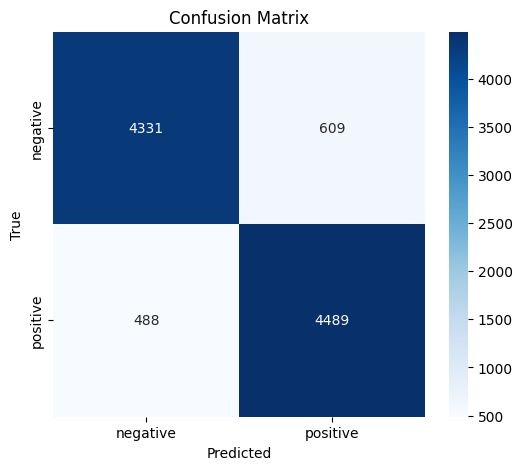

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Check the shape of the transformed feature matrix
print(x_train.shape)

# Check tfidf features
print(tfidf.get_feature_names_out()[:20])

(39665,)
['007' '010' '10' '100' '1000' '10000' '101' '1010' '11' '110' '12' '13'
 '13th' '14' '15' '150' '16' '17' '18' '18th']


It looks like our TfidfVectorizer is capturing numeric terms as features, which may not be meaningful in our context.

So, I will be expermenting with numbers removed to see if it makes any difference.

In [ ]:
# Prepare my test cases
new_sentences = [
    "I loved this movie! It was amazing!",
    "This film was terrible, I regret watching it.",
    "It was okay, but not great.",
    "The story was boring and the acting was weak.",
    "I hate the selfishness in you",
    "I hate anyone who can hurt you",
    "I hate to admit it, but that was really clever.",
    "You are a bad person",
    "You are a good person"
]

# Clean the new sentences
new_sentences_cleaned = [deep_cleaning(sentence) for sentence in new_sentences]

In [ ]:
# Transform the new sentences using the same vectorizer
new_sentences_tfidf_1 = tfidf.transform(new_sentences_cleaned)

# Predict the sentiment using the trained Logistic Regression model
predictions_1 = lr.predict(new_sentences_tfidf_1)

# Convert predictions to readable labels (1: positive, 0: negative)
predicted_sentiments_1 = ['positive' if pred == 1 else 'negative' for pred in predictions_1]

# Display the results
lr_predictions_df = pd.DataFrame({
    'Sentence': new_sentences,
    'Predicted Sentiment': predicted_sentiments_1
})

# Display the DataFrame
lr_predictions_df

,Sentence,Predicted Sentiment
0,I loved this movie! It was amazing!,positive
1,"This film was terrible, I regret watching it.",negative
2,"It was okay, but not great.",positive
3,The story was boring and the acting was weak.,negative
4,I hate the selfishness in you,positive
5,I hate anyone who can hurt you,positive
6,"I hate to admit it, but that was really clever.",positive
7,You are a bad person,negative
8,You are a good person,positive


## Adjustments with Logistic Regression --> ignore numbers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df_deep['review'], cleaned_df_deep['sentiment'], test_size=0.2, random_state=42
)

# Apply TfidfVectorizer
tfidf_2 = TfidfVectorizer(
    max_features=10000,    # Limit the number of features to speed up and reduce noise
    stop_words='english',  # Remove common stopwords
    ngram_range=(1, 2),    # Capture both unigrams and bigrams
    token_pattern=r'\b[a-zA-Z]+\b'  # Only keep words with letters, removing numbers and special characters
)

# Transform the training and testing data
X_train_tfidf_2 = tfidf_2.fit_transform(X_train)
X_test_tfidf_2 = tfidf_2.transform(X_test)

# Train a Logistic Regression model
lr_2 = LogisticRegression(max_iter=1000)
lr_2.fit(X_train_tfidf_2, y_train)

# Predict and evaluate the model
y_pred_2 = lr_2.predict(X_test_tfidf_2)
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.87      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [ ]:
# First 20 features
print(tfidf_2.get_feature_names_out()[:20])

['aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'abilities' 'ability' 'able'
 'able make' 'aboard' 'abomination' 'abortion' 'abound' 'abraham' 'abroad'
 'abrupt' 'abruptly' 'absence' 'absent' 'absolute']


No longer numeric features is shown, let's see if it makes any difference.

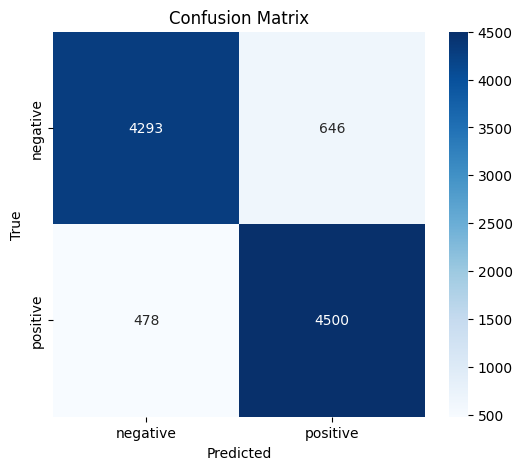

In [ ]:
# Compute the confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Transform the new sentences using the same vectorizer
new_sentences_tfidf_2 = tfidf_2.transform(new_sentences_cleaned)

# Predict the sentiment using the trained Logistic Regression model
predictions_2 = lr_2.predict(new_sentences_tfidf_2)

# Convert predictions to readable labels (1: positive, 0: negative)
predicted_sentiments_2 = ['positive' if pred == 1 else 'negative' for pred in predictions_2]

# Display the results
lr_2_predictions_df = pd.DataFrame({
    'Sentence': new_sentences,
    'Predicted Sentiment': predicted_sentiments_2
})

# Display the DataFrame
lr_2_predictions_df

,Sentence,Predicted Sentiment
0,I loved this movie! It was amazing!,positive
1,"This film was terrible, I regret watching it.",negative
2,"It was okay, but not great.",positive
3,The story was boring and the acting was weak.,negative
4,I hate the selfishness in you,positive
5,I hate anyone who can hurt you,positive
6,"I hate to admit it, but that was really clever.",positive
7,You are a bad person,negative
8,You are a good person,positive


Both models perform very similarly, with minor differences

It seems like our Logistic Regression model is struggling to handle contextual nuances in these sentences, particularly with homonyms like "hate", my guess is maybe the model learned from the data that positive sentiment often includes strong emotions, and the use of "hate" in certain contexts might be misleading for the model.

Now, I will be utilizing the power of transformers and see.

# BERT

## Experiment 1: With deap cleansing performed (512 max_len)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df_deep.review,cleaned_df_deep.sentiment, test_size=0.2, random_state = 42 , stratify = cleaned_df_deep.sentiment)

In [ ]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 39665
Testing set size: 9917


BERT requires input to be tokenized in a specific way. I will use the BertTokenizer for this purpose.

I will be using bert-base-uncased to ignore casing of characters as the IMDB dataset contains text written by internet users who may be inconsistent with their use of capitalization. For example, some users may omit capitalization where it is expected or use capitalization for dramatic effect (to show excitement, frustration, etc.).

**BERT requires input sequences to be of the same length.**


*   Padding: Add padding tokens ([PAD]) to shorter sequences to match the maximum sequence length.
*   Truncation: Cut longer sequences to fit the maximum sequence length.

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True, # Add padding tokens ([PAD]) to shorter sequences to match the maximum sequence length.
        truncation=True, # Truncate sequences longer than max_length.
        max_length=512
    )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [ ]:
# Tokenize training and testing data
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

In [ ]:
# Confirm outputs to ensure everything is done right
print("Example input_ids:", train_encodings['input_ids'][0])
print("Example attention_mask:", train_encodings['attention_mask'][0])

Example input_ids: [101, 2028, 15333, 6806, 21927, 2015, 9390, 2036, 2147, 11325, 2729, 2966, 4322, 2086, 2464, 2111, 3280, 19610, 4747, 21252, 9597, 2668, 9099, 20523, 2015, 3230, 3365, 9281, 2668, 2141, 26835, 2015, 2464, 2195, 5022, 2468, 5667, 5665, 26835, 2015, 10572, 9099, 25608, 2098, 2668, 2036, 2657, 2195, 15333, 6806, 21927, 2015, 9390, 2409, 3280, 10214, 2668, 2656, 2086, 2492, 2196, 2941, 2464, 4148, 2975, 3160, 2428, 29205, 10214, 2668, 9099, 20523, 2015, 2451, 2312, 5770, 2075, 2645, 3277, 3277, 15333, 6806, 21927, 2015, 9390, 7191, 2028, 2442, 14689, 18249, 2668, 20080, 4861, 4067, 3185, 4352, 7928, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

We can feed data to BERT whether using HuggingFace DataLoader or create custom class.

For relatively large datasets, it's recommended to create custom class, so I will be creating one. Also, it efficient  for memory as the data is processed on-the-fly, so you don't need to load everything into memory at once.

In [ ]:
class IMDBMovies(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# Create dataset objects
train_dataset = IMDBMovies(train_encodings, y_train.tolist())
test_dataset = IMDBMovies(test_encodings, y_test.tolist())

###  Fine-tuning the pre-trained BERT model on our case.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
!pip uninstall wandb -y

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: wandb 0.18.3
Uninstalling wandb-0.18.3:
  Successfully uninstalled wandb-0.18.3


In [ ]:
# Initialize the model
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
# Set up EarlyStoppingCallback -->  Patience: number of epochs with no improvement
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./BERTResults',
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation --> Evaluation doesn't compute gradients, so it consumes less memory.
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./BERTLogs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=None
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    # Calculate weighted precision, recall, F1-score, and support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

In [ ]:
# Train the Model:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.320300,0.242351,0.902087,0.901765,0.907039,0.902087
2,0.163200,0.226433,0.920440,0.920422,0.920939,0.920440
3,0.068300,0.309810,0.924776,0.924774,0.924789,0.924776


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.au

TrainOutput(global_step=3720, training_loss=0.17984327689133664, metrics={'train_runtime': 7016.3446, 'train_samples_per_second': 16.96, 'train_steps_per_second': 0.53, 'total_flos': 3.13089000325632e+16, 'train_loss': 0.17984327689133664, 'epoch': 3.0})

In [ ]:
# Evaluate the model
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.3098098039627075,
 'eval_accuracy': 0.9247756377936877,
 'eval_f1': 0.9247740543987282,
 'eval_precision': 0.9247893982915426,
 'eval_recall': 0.9247756377936877,
 'eval_runtime': 179.2243,
 'eval_samples_per_second': 55.333,
 'eval_steps_per_second': 0.435,
 'epoch': 3.0}

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



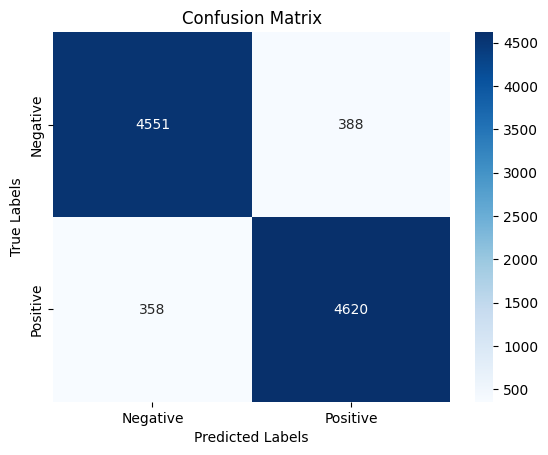

In [ ]:
# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1).tolist()

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Test the model against new sentences

# Tokenize the new sentences
new_encodings = tokenizer(new_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move the model and inputs to the correct device (e.g., GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Get predictions
bert.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = bert(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to labels
label_map = {0: "negative", 1: "positive"}
mapped_labels = [label_map[pred.item()] for pred in predictions]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Sentence": new_sentences,
    "Prediction": mapped_labels
})

# Display results
results_df

,Sentence,Prediction
0,I loved this movie! It was amazing!,positive
1,"This film was terrible, I regret watching it.",negative
2,"It was okay, but not great.",negative
3,The story was boring and the acting was weak.,negative
4,I hate the selfishness in you,negative
5,I hate anyone who can hurt you,positive
6,"I hate to admit it, but that was really clever.",positive
7,You are a bad person,negative
8,You are a good person,positive


**The model is able to classify the sentiments correct as well as when homonyms are present.**

In [ ]:
# Save the model to the output directory
output_dir = './saved_models'
bert.save_pretrained(output_dir)

# Save the tokenizer used for tokenizing inputs
tokenizer.save_pretrained(output_dir)

('./saved_models/tokenizer_config.json',
 './saved_models/special_tokens_map.json',
 './saved_models/vocab.txt',
 './saved_models/added_tokens.json',
 './saved_models/tokenizer.json')

In [ ]:
import shutil

# Create a zip file of the saved model
shutil.make_archive('saved_model', 'zip', './saved_models')

'/kaggle/working/saved_model.zip'

## Experiment 2: With intensive cleaning (max length = 128)

In [ ]:
# Split the dataset for minimal cleaning version
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df_deep.review,
    cleaned_df_deep.sentiment,
    test_size=0.2,
    random_state=42,
    stratify=cleaned_df_deep.sentiment
)

# Tokenizer setup for minimal cleaning
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,  # Add padding tokens ([PAD]) to shorter sequences to match the maximum sequence length.
        truncation=True,  # Truncate sequences longer than max_length.
        max_length=128    # I decrease the max_length for resources issues.
    )

# Tokenize training and testing data for minimal cleaning
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Dataset object remains the same
class IMDBMovies(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects for minimal cleaning
train_dataset = IMDBMovies(train_encodings, y_train.tolist())
test_dataset = IMDBMovies(test_encodings, y_test.tolist())

# Set WANDB disabled
import os
os.environ["WANDB_DISABLED"] = "true"
!pip uninstall wandb -y

# Initialize the model for minimal cleaning
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Set up EarlyStoppingCallback --> Patience: number of epochs with no improvement
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./BERTResults_minimal',  # Change the output directory for minimal cleaning results
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation --> Evaluation doesn't compute gradients, so it consumes less memory.
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Strength of weight decay
    logging_dir='./BERTLogs_minimal',  # Directory for storing logs for minimal cleaning
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=None
)

# Compute metrics remains the same
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    # Calculate weighted precision, recall, F1-score, and support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer for minimal cleaning
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1).tolist()

# Confusion matrix for minimal cleaning
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix for minimal cleaning
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Minimal Cleaning')
plt.show()

# Test the model against new sentences

# Tokenize the new sentences
new_encodings = tokenizer(new_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move the model and inputs to the correct device (e.g., GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Get predictions
bert.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = bert(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to labels
label_map = {0: "negative", 1: "positive"}
mapped_labels = [label_map[pred.item()] for pred in predictions]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Sentence": new_sentences,
    "Prediction": mapped_labels
})

# Display results
results_df

## Experiment 3: With inimal cleaning (max length = 512)

In [ ]:
# Split the dataset for minimal cleaning version
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df_minimal.review,
    cleaned_df_minimal.sentiment,
    test_size=0.2,
    random_state=42,
    stratify=cleaned_df_minimal.sentiment
)

# Tokenizer setup for minimal cleaning
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,  # Add padding tokens ([PAD]) to shorter sequences to match the maximum sequence length.
        truncation=True,  # Truncate sequences longer than max_length.
        max_length=512
    )

# Tokenize training and testing data for minimal cleaning
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Dataset object remains the same
class IMDBMovies(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects for minimal cleaning
train_dataset = IMDBMovies(train_encodings, y_train.tolist())
test_dataset = IMDBMovies(test_encodings, y_test.tolist())

# Set WANDB disabled
import os
os.environ["WANDB_DISABLED"] = "true"
!pip uninstall wandb -y

# Initialize the model for minimal cleaning
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Set up EarlyStoppingCallback --> Patience: number of epochs with no improvement
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./BERTResults_minimal',  # Change the output directory for minimal cleaning results
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation --> Evaluation doesn't compute gradients, so it consumes less memory.
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Strength of weight decay
    logging_dir='./BERTLogs_minimal',  # Directory for storing logs for minimal cleaning
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=None
)

# Compute metrics remains the same
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    # Calculate weighted precision, recall, F1-score, and support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer for minimal cleaning
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1).tolist()

# Confusion matrix for minimal cleaning
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix for minimal cleaning
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Minimal Cleaning')
plt.show()

# Test the model against new sentences

# Tokenize the new sentences
new_encodings = tokenizer(new_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move the model and inputs to the correct device (e.g., GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Get predictions
bert.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = bert(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to labels
label_map = {0: "negative", 1: "positive"}
mapped_labels = [label_map[pred.item()] for pred in predictions]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Sentence": new_sentences,
    "Prediction": mapped_labels
})

# Display results
results_df

## Experiment 4: With data which minimal cleaning is performed (128 max length)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.226100,0.273815,0.885550,0.885426,0.887454,0.885550
2,0.113800,0.291491,0.897953,0.897804,0.900035,0.897953
3,0.049700,0.388201,0.903802,0.903781,0.904062,0.903802


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.au

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



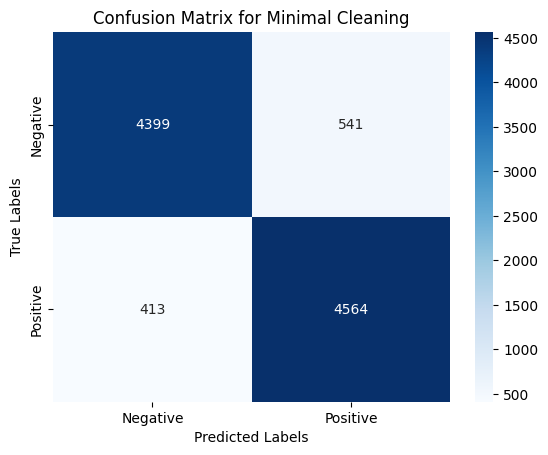

,Sentence,Prediction
0,I loved this movie! It was amazing!,positive
1,"This film was terrible, I regret watching it.",negative
2,"It was okay, but not great.",negative
3,The story was boring and the acting was weak.,negative
4,I hate the selfishness in you,positive
5,I hate anyone who can hurt you,positive
6,"I hate to admit it, but that was really clever.",positive
7,You are a bad person,positive
8,You are a good person,positive


In [ ]:
# Split the dataset for minimal cleaning version
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df_minimal.review,
    cleaned_df_minimal.sentiment,
    test_size=0.2,
    random_state=42,
    stratify=cleaned_df_minimal.sentiment
)

# Tokenizer setup for minimal cleaning
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,  # Add padding tokens ([PAD]) to shorter sequences to match the maximum sequence length.
        truncation=True,  # Truncate sequences longer than max_length.
        max_length=128    # I decrease the max_length for resources issues.
    )

# Tokenize training and testing data for minimal cleaning
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Dataset object remains the same
class IMDBMovies(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects for minimal cleaning
train_dataset = IMDBMovies(train_encodings, y_train.tolist())
test_dataset = IMDBMovies(test_encodings, y_test.tolist())

# Set WANDB disabled
import os
os.environ["WANDB_DISABLED"] = "true"
!pip uninstall wandb -y

# Initialize the model for minimal cleaning
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Set up EarlyStoppingCallback --> Patience: number of epochs with no improvement
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./BERTResults_minimal',  # Change the output directory for minimal cleaning results
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation --> Evaluation doesn't compute gradients, so it consumes less memory.
    warmup_steps=500,  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # Strength of weight decay
    logging_dir='./BERTLogs_minimal',  # Directory for storing logs for minimal cleaning
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=None
)

# Compute metrics remains the same
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    # Calculate weighted precision, recall, F1-score, and support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer for minimal cleaning
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1).tolist()

# Confusion matrix for minimal cleaning
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix for minimal cleaning
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Minimal Cleaning')
plt.show()

# Test the model against new sentences

# Tokenize the new sentences
new_encodings = tokenizer(new_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move the model and inputs to the correct device (e.g., GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Get predictions
bert.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = bert(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to labels
label_map = {0: "negative", 1: "positive"}
mapped_labels = [label_map[pred.item()] for pred in predictions]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Sentence": new_sentences,
    "Prediction": mapped_labels
})

# Display results
results_df

# RoBERTa

Since minimal cleaning already confirmed its effectiveness and RoBERTa is known for that it has been pre-trained on vast amounts of data, allowing it to better handle nuances like slang, informal language, and various forms of expression. So, I will be using it for minimal cleaned data along max length of 512.

In [ ]:
# Load pretrained RoBERTa model and tokenizer
Roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
Roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.165400,0.160277,0.940910,0.940896,0.941448,0.940910
2,0.096100,0.163536,0.952707,0.952699,0.952947,0.952707
3,0.013200,0.192483,0.955329,0.955329,0.955330,0.955329


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.au

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



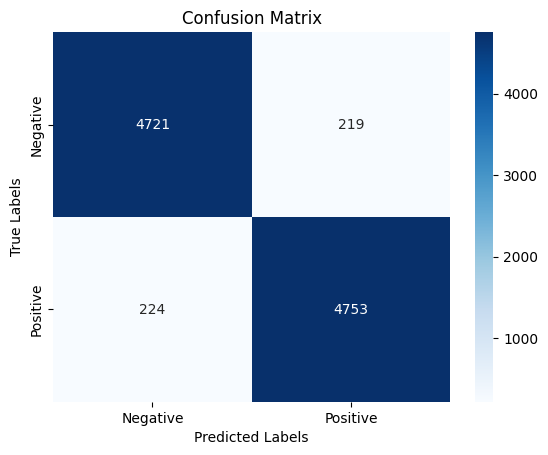

NameError: name 'roberta' is not defined

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_df_minimal.review,
    cleaned_df_minimal.sentiment,
    test_size=0.2,
    random_state=42,
    stratify=cleaned_df_minimal.sentiment
)

# Initialize the tokenizer for RoBERTa

# Tokenize the data
def tokenize_function(texts):
    return Roberta_tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=512
    )

# Tokenize training and testing data
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Dataset class for RoBERTa
class IMDBMovies(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects
train_dataset = IMDBMovies(train_encodings, y_train.tolist())
test_dataset = IMDBMovies(test_encodings, y_test.tolist())

# Set up EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./RoBERTaResults',
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./RoBERTaLogs',      # Directory for storing logs
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=None
)

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=Roberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

# Train the Model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1).tolist()

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Test the model against new sentences
new_encodings = Roberta_tokenizer(new_sentences, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Move the model and inputs to the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Roberta.to(device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Get predictions
Roberta.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = Roberta(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Map predictions to labels
label_map = {0: "negative", 1: "positive"}
mapped_labels = [label_map[pred.item()] for pred in predictions]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Sentence": new_sentences,
    "Prediction": mapped_labels
})

# Display results
  results_df

,Sentence,Prediction
0,I loved this movie! It was amazing!,positive
1,"This film was terrible, I regret watching it.",negative
2,"It was okay, but not great.",negative
3,The story was boring and the acting was weak.,negative
4,I hate the selfishness in you,negative
5,I hate anyone who can hurt you,negative
6,"I hate to admit it, but that was really clever.",positive
7,You are a bad person,negative
8,You are a good person,positive
